# Homework 4 Part 2 - Solutions

**This is an individual assignment.**

---

Write your own code and justify all your answers. You may repurpose any functions built during lecture. You may use ```scikit-learn``` functions.

---

In [1]:
# Import libraries and magics

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy import stats
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.feature_selection import RFE
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding as LLE, TSNE
from sklearn.svm import SVC

from time import time
from warnings import filterwarnings

import tensorflow.keras as keras

---

# Exercise 1 (15 points)

**In this problem, you will be working with the [MNIST Data Set](http://yann.lecun.com/exdb/mnist/) to extract features, perform classification using the SVM algorithm and evaluate your results using metrics such as accuracy, ROC curve and confusion matrices.**

**The MNIST data set contains $28\times 28$ images of handwritten digits (class labels 0, 1, 2, 3, 4, 5, 6, 7, 8 and 9). This data set has 60,000 images for training and 10,000 images for testing. Each image is a 8-bit grayscale image and so the intensity values per pixel range from 0-255.**

**The following code cell loads the MNIST data set and displays some examples. (The data is already available in your repository as "mnist_train.csv" and "mnist_test.csv".)**

In [2]:
# Loading MNIST data set
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size

# Loading Training Samples
train_data = np.loadtxt("mnist_train.csv", delimiter=",")
X_train = train_data[:,1:]
t_train = train_data[:,0]

# Loading Test Samples
test_data = np.loadtxt("mnist_test.csv", delimiter=",") 
X_test = test_data[:,1:]
t_test = test_data[:,0]

X_train.shape, t_train.shape, X_test.shape, t_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

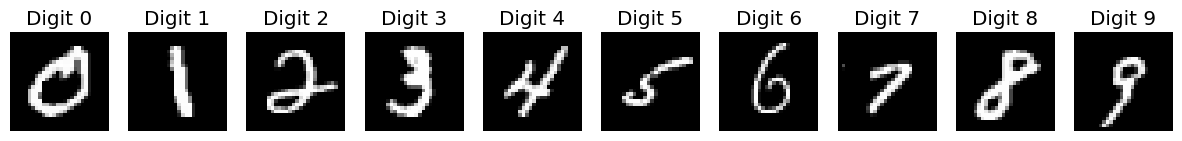

In [3]:
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[np.where(t_train==i)[0][1],:].reshape((28,28)), cmap='gray')
    plt.title('Digit '+str(i)); plt.axis('off');

**Using this dataset, answer the following questions:**

1. **Create a PCA object using ```scikit-learn``` functions and plot the cumulative explained variance ratio. How many principal components (PCs) would you have to extract in order to preserve 90% of the explained variance in the data?**
    * **Be sure to apply any necessary preprocessing.**

In [4]:
# Problem 1

pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('PCA', PCA())])

pipe.fit(X_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('PCA', PCA())])

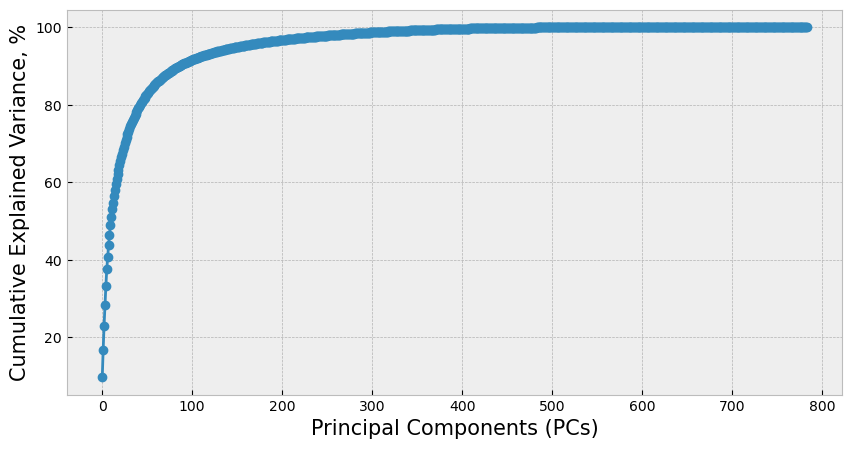

In [5]:
# Cumulative Explained Variance

plt.figure(figsize=(10,5))
plt.plot(range(784), 100*np.cumsum(pipe.named_steps['PCA'].explained_variance_ratio_),'-o')
plt.xlabel('Principal Components (PCs)',size=15)
plt.ylabel('Cumulative Explained Variance, %', size=15);

In [6]:
num_pcs = np.where(np.cumsum(pipe.named_steps['PCA'].explained_variance_ratio_)>=0.9)[0][0]

print('We need ',num_pcs+1, 
      ' in order to explain ',100*np.cumsum(pipe.named_steps['PCA'].explained_variance_ratio_)[num_pcs],
     '% of the variance in the data')

We need  87  in order to explain  90.00718580239364 % of the variance in the data


2. **Plot the first 9 principal components you found in (3) with the training data. Based on this data, what is each principal component representing?**

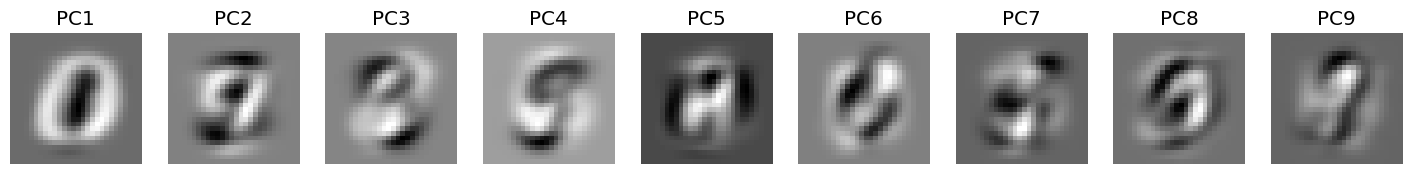

In [7]:
# Problem 2 - Visualizing top 9 eigenvectors

plt.figure(figsize=(20,5))
for i in range(9):
    plt.subplot(1,10,i+1)
    plt.imshow(pipe.named_steps['PCA'].components_[i,:].reshape(28,28), cmap='gray')
    plt.title('PC'+str(i+1)); plt.axis('off');

3. **Reconstruct test images using the number of PCs you found in (1). Display examples.**

In [8]:
# Redefining the pipeline

pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('PCA', PCA(n_components=87))])

pipe.fit(X_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('PCA', PCA(n_components=87))])

In [9]:
# Finding PCA features for test set
X_test_pca = pipe.transform(X_test)

X_test_pca.shape

(10000, 87)

In [10]:
# matrix containing the eigenvectors/PC directions
A = pipe.named_steps['PCA'].components_ 

A.shape

(87, 784)

The transformation is given as:

$$\mathbf{Y} = \mathbf{A}\mathbf{X}$$

where $\mathbf{A}$ is the matrix containing the eigenvectors (PC directions) in its rows.

Thus, we we want to recover $\mathbf{X}$, we multiply by the **pseudo-inverse** of the matrix $\mathbf{A}$ on both sides of the equation.

$$\tilde{\mathbf{X}} = \mathbf{A}^{\dagger}\mathbf{Y}$$

In [11]:
# Reconstructing test image with the top 'num_pcs' eigenvectors found during training

X_test_reconstructed =  pipe.inverse_transform(X_test_pca)

X_test_reconstructed.shape

(10000, 784)

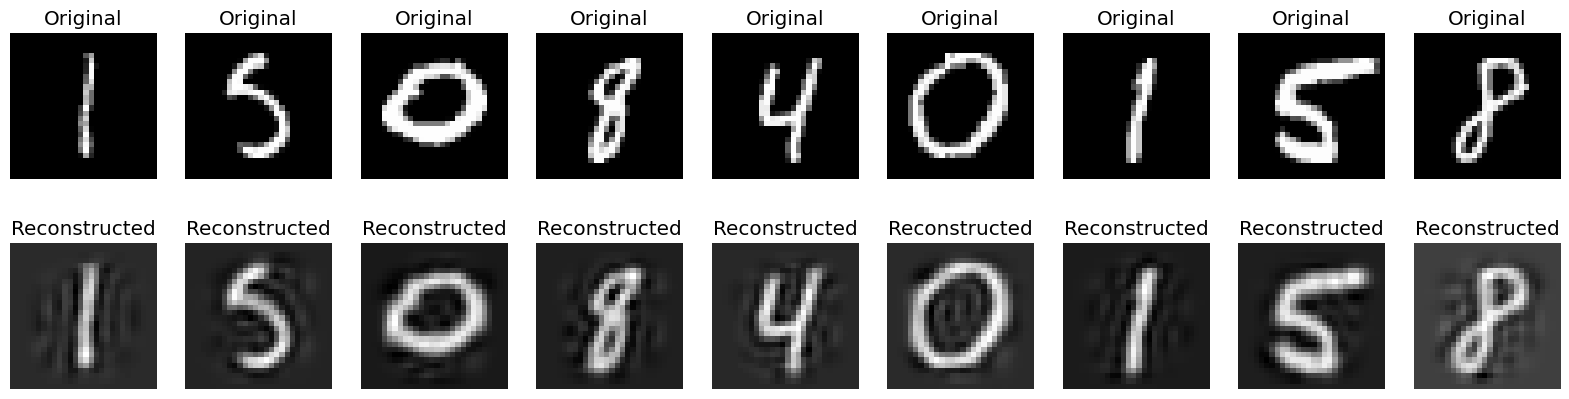

In [12]:
N = 9
idx = np.random.choice(range(X_test.shape[0]),replace=False,size=N)
plt.figure(figsize=(20,5))
grid_loc=1
for i in range(N):
    plt.subplot(2,N,grid_loc)
    plt.imshow(X_test[idx[i],:].reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.title('Original');

    plt.subplot(2,N,grid_loc+N)
    plt.imshow(X_test_reconstructed[idx[i],:].reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.title('Reconstructed');
    grid_loc+=1

4. **Train the following ```scikit-learn``` pipelines:**

    1. **Pipeline 1 - scales data, reduces dimensions with PCA and train an SVM with RBF kernel.**
    
    2. **Pipeline 2 - scales data, and train an SVM with RBF kernel.**

In [13]:
# Problem 4
filterwarnings('ignore')

# Pipeline with PCA
t0 = time()
pipe1 = Pipeline([('scaler', MinMaxScaler()), 
                 ('PCA', PCA(n_components=87)),
                 ('LR', LogisticRegression(multi_class='multinomial',penalty='none'))])
pipe1.fit(X_train, t_train)
t1 = time()
print("Training Time: %.2g sec" % (t1 - t0))
y_train_pipe1 = pipe1.predict(X_train)
y_test_pipe1 = pipe1.predict(X_test)


# Pipeline without PCA
t0 = time()
pipe2 = Pipeline([('scaler', MinMaxScaler()),
                 ('LR', LogisticRegression(multi_class='multinomial',penalty='none'))])
pipe2.fit(X_train, t_train)
t1 = time()
print("Training Time: %.2g sec" % (t1 - t0))
y_train_pipe2 = pipe2.predict(X_train)
y_test_pipe2 = pipe2.predict(X_test)

Training Time: 7 sec
Training Time: 11 sec


As we see, pipeline 1 (with dimensionality reduction) is the fastest to implement. So reducing dimensions is helping in computational time during training.

In [14]:
filterwarnings('ignore')

scores_pipe1 = cross_val_score(pipe1, 
                                X_train, t_train,
                                n_jobs=-1,
                                cv=10, 
                                scoring='accuracy')

scores_pipe2 = cross_val_score(pipe2, 
                                X_train, t_train,
                                n_jobs=-1,
                                cv=10, 
                                scoring='accuracy')

/Users/catiaspsilva/miniconda3/envs/fml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/catiaspsilva/miniconda3/envs/fml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

5. **Evaluate performance in training and test sets.**

In [15]:
# Performance measures in training/test with pipeline 1
print('Training Set Performance\n')
print('Classification Report')
print(classification_report(t_train, y_train_pipe1))
print('Confusion Matrix')
print(confusion_matrix(t_train, y_train_pipe1))
print('\nValidation Set Performance')
print('95% CI: ', stats.t.interval(0.95, len(scores_pipe1) - 1,
                 loc=scores_pipe1.mean(),
                 scale=scores_pipe1.std(ddof=1)/np.sqrt(len(scores_pipe1))))
print('===================================================================')

print('\n\n Test Set Performance\n')
print('Classification Report')
print(classification_report(t_test, y_test_pipe1))
print('Confusion Matrix')
print(confusion_matrix(t_test, y_test_pipe1))

Training Set Performance

Classification Report
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      5923
         1.0       0.95      0.97      0.96      6742
         2.0       0.92      0.90      0.91      5958
         3.0       0.91      0.89      0.90      6131
         4.0       0.92      0.93      0.93      5842
         5.0       0.88      0.87      0.87      5421
         6.0       0.94      0.96      0.95      5918
         7.0       0.93      0.94      0.94      6265
         8.0       0.89      0.88      0.88      5851
         9.0       0.90      0.90      0.90      5949

    accuracy                           0.92     60000
   macro avg       0.92      0.92      0.92     60000
weighted avg       0.92      0.92      0.92     60000

Confusion Matrix
[[5728    1   23    8    9   56   40   11   40    7]
 [   1 6562   27   22    7   30    3   14   66   10]
 [  29   61 5343   88   72   40   80   80  138   27]
 [  20   27  130 

In [16]:
# Performance measures in training/test with pipeline 2
print('Training Set Performance\n')
print('Classification Report')
print(classification_report(t_train, y_train_pipe2))
print('Confusion Matrix')
print(confusion_matrix(t_train, y_train_pipe2))
print('\nValidation Set Performance')
print('95% CI: ', stats.t.interval(0.95, len(scores_pipe2) - 1,
                 loc=scores_pipe2.mean(),
                 scale=scores_pipe2.std(ddof=1)/np.sqrt(len(scores_pipe2))))
print('===================================================================')

print('\n\n Test Set Performance\n')
print('Classification Report')
print(classification_report(t_test, y_test_pipe2))
print('Confusion Matrix')
print(confusion_matrix(t_test, y_test_pipe2))

Training Set Performance

Classification Report
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      5923
         1.0       0.96      0.98      0.97      6742
         2.0       0.93      0.92      0.92      5958
         3.0       0.92      0.91      0.91      6131
         4.0       0.94      0.94      0.94      5842
         5.0       0.91      0.90      0.90      5421
         6.0       0.95      0.97      0.96      5918
         7.0       0.95      0.94      0.95      6265
         8.0       0.91      0.90      0.90      5851
         9.0       0.91      0.92      0.92      5949

    accuracy                           0.94     60000
   macro avg       0.93      0.93      0.93     60000
weighted avg       0.94      0.94      0.94     60000

Confusion Matrix
[[5771    1   13    9   13   38   32    8   32    6]
 [   1 6587   29   20    6   21    4   13   51   10]
 [  26   49 5459   89   60   23   56   53  118   25]
 [  16   26  121 

---

# Exercise 2 (15 points)

**In this problem, you will be working with the [California Housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html). The California Housing dataset consists of 20,640 samples, each described with 8 features. Let's import it:**

In [2]:
from sklearn.datasets import fetch_california_housing 
housing = fetch_california_housing()
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
X = housing.data # feature matrix (attributes/features are described above)

t = housing.target # target vector (median house value expressed in $100,000)

X.shape, t.shape

((20640, 8), (20640,))

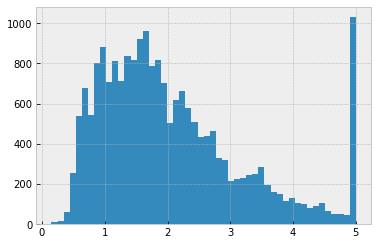

In [4]:
plt.hist(t, bins=50);

The distribution of the target variable is not uniform. So a random partition may result in one of the sets not containing samples with large median income values.

We can encode the target values to labels and use those to perform a stratified partition.

Below is an example of a categorical encoding:

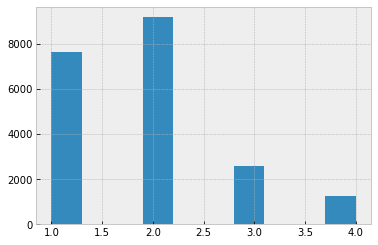

In [5]:
import pandas as pd
income_cat = pd.cut(t, 
                    bins=[0., 1.5, 3.0, 4.5, 6., np.inf], 
                    labels=[1, 2, 3, 4, 5])

plt.hist(income_cat);

**Answer the following questions:**

1. (1 point) **Partition the data into a *full training set* and a test set. Use a 80/20 stratified split with a fixed ```random_state```. Then partition the *full training set* into a train set and a validation set. For this last partition, use a 70/30 stratified split with a fixed ```random_state```.**

In [6]:
from sklearn.model_selection import train_test_split 

X_train_full, X_test, t_train_full, t_test, income_cat_training, income_cat_test = train_test_split(X, t, income_cat,
                                                                                                 test_size=0.2, 
                                                                                                 stratify=income_cat,
                                                                                                 random_state=0) 

X_train, X_valid, t_train, t_valid, income_cat_train, income_cat_valid = train_test_split(X_train_full, 
                                                                                          t_train_full, income_cat_training,
                                                                                          test_size=0.3,
                                                                                          stratify=income_cat_training,
                                                                                          random_state=0) 

X_train.shape, X_valid.shape, X_test.shape, t_train.shape, t_valid.shape, t_test.shape

((11558, 8), (4954, 8), (4128, 8), (11558,), (4954,), (4128,))

2. (1 point) **Apply the standardization scaling to the train, validation and test sets. Use the train set to find the mean and standard deviation.**

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid) 
X_test = scaler.transform(X_test)

X_train.shape, t_train.shape, X_valid.shape, t_valid.shape, X_test.shape, t_test.shape

((11558, 8), (11558,), (4954, 8), (4954,), (4128, 8), (4128,))

3. (5 points) **Use the Sequential API to build an MLP with 2 hidden layers with the Leaky ReLU activation function and associated ```alpha=0.2```. The first hidden layer should have 50 neurons and the second 10 neurons. How many neurons should you include in the input and output layers? what should be the activation function in the output layer?**

The input layer will have as many input neurons as there are attributes, thus a total of 8 units. The output layer will have as many units as the dimensionality of the target response. In this case our target is 1-D, for each sample, we wish to predict its median value.

As seen below, since the target is always positive (not scaled), and greater than 1, the most activation functions for the output layer are the ReLU or linear functions.

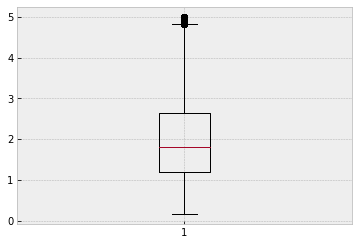

In [8]:
plt.boxplot(t);

In [9]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[8]),
    keras.layers.Dense(50),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dense(10),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dense(1, activation='relu')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 50)                450       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 971
Trainable params: 971
Non-trainable pa

2023-11-30 22:14:58.517091: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 22:14:59.839213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4e:00.0, compute capability: 8.0
2023-11-30 22:14:59.841177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:bd:00.0, compute capability: 8.0


4. (3 points) **Compile the model with the Mean Squared Error [loss function](https://keras.io/api/losses/), the Adam [optimizer](https://keras.io/api/optimizers/) with learning rate of 0.001, and the ```MeanSquaredError``` [performance metric](https://keras.io/api/metrics/).**

In [10]:
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=keras.metrics.MeanSquaredError(name='mse'))

5. (2 points) **Train the model using the train and validation sets with online learning, 200 epochs and early stopping callback with a patience of 10 (on the loss value for the validation set). Plot the learning curves. Discuss your observations.**


In [11]:
history = model.fit(X_train, t_train, epochs=200, batch_size=1,
                    validation_data=(X_valid, t_valid),
                    callbacks=keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'))

Epoch 1/200
  157/11558 [..............................] - ETA: 11s - loss: 3.7352 - mse: 3.7352

2023-11-30 22:15:03.768256: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


11558/11558 [==============================] - 18s 1ms/step - loss: 0.5113 - mse: 0.5113 - val_loss: 0.4045 - val_mse: 0.4045
Epoch 2/200
11558/11558 [==============================] - 17s 1ms/step - loss: 0.3910 - mse: 0.3910 - val_loss: 0.4159 - val_mse: 0.4159
Epoch 3/200
11558/11558 [==============================] - 17s 1ms/step - loss: 0.3695 - mse: 0.3695 - val_loss: 0.3677 - val_mse: 0.3677
Epoch 4/200
11558/11558 [==============================] - 14s 1ms/step - loss: 0.3501 - mse: 0.3501 - val_loss: 0.3540 - val_mse: 0.3540
Epoch 5/200
11558/11558 [==============================] - 17s 1ms/step - loss: 0.3419 - mse: 0.3419 - val_loss: 0.3552 - val_mse: 0.3552
Epoch 6/200
11558/11558 [==============================] - 14s 1ms/step - loss: 0.3336 - mse: 0.3336 - val_loss: 0.3299 - val_mse: 0.3299
Epoch 7/200
11558/11558 [==============================] - 14s 1ms/step - loss: 0.3573 - mse: 0.3573 - val_loss: 0.3168 - val_mse: 0.3168
Epoch 8/200
11558/11558 [=====================

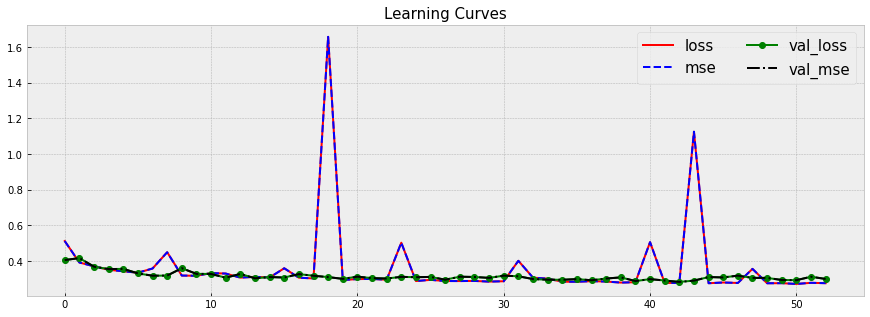

In [12]:
key_names = list(history.history.keys())
colors = ['-r','--b','-og','-.k']

plt.figure(figsize=(15,5))
for i in range(len(key_names)):
    plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
plt.legend(fontsize=15,ncol=2)
plt.title('Learning Curves', size=15);

6. (2 points) **Evaluate the mean squared error performance in the train and test sets.**

In [13]:
mse_train = model.evaluate(X_train, t_train)

mse_test = model.evaluate(X_test, t_test)

129/129 [==============================] - 0s 1ms/step - loss: 0.3102 - mse: 0.3102


7. (2 points) **Predict the housing prices for the train and test sets. Use these predictions to calculate the [$r^2$ score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html).**

In [14]:
y_train = model.predict(X_train)
y_valid = model.predict(X_valid)
y_test = model.predict(X_test)

In [15]:
from sklearn.metrics import r2_score

print(r2_score(t_train, y_train))
print(r2_score(t_valid, y_valid))
print(r2_score(t_test, y_test))

0.8000683143129845
0.7754459056129722
0.7668613862059209


---

# Exercise 3 (15 points)

**In this problem you will again be working with the Breast Cancer Dataset available in ```scikit-learn```.**

**This dataset contains 569 samples each described by 30 attributes. Each 30-dimensional sample is labeled as benign (label 1) or malignant (label 0). Let's import the data.**

In [16]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

# Obtaining feature matrix and target labels
X = cancer.data
t = cancer.target

X.shape, t.shape

((569, 30), (569,))

In [17]:
X_training, X_test, t_training, t_test = train_test_split(X, t, 
                                                          test_size=0.2, 
                                                          shuffle=True, stratify=t, 
                                                          random_state=0)

X_train, X_val, t_train, t_val = train_test_split(X_training, t_training, 
                                                  test_size=0.3, 
                                                  shuffle=True, stratify=t_training, 
                                                  random_state=0)

1. (7 points) **Train an MLP with the Sequential API with 2 hidden layers: 1st hidden layer with 100 units and the relu activation function, 2nd hidden layer with 50 units with the relu activation function. Compile the model with the Adam optimization with $\eta=0.01$, track the metric accuracy, and add an early stopping callback on ```val_loss``` with 10 epochs patience.**

**Encode the input and output layers to solve this binary classification task. Choose appropriate activation function for the output layer and objective function.**

**Report the classification report in training and test sets. Discuss results.**

In [18]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[30]),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
model.compile(loss=keras.losses.BinaryCrossentropy(),
             optimizer=keras.optimizers.Adam(learning_rate=0.01),
             metrics=['accuracy'])

In [20]:
model.fit(X_train, t_train, epochs=100, batch_size=32,
         validation_data=(X_val, t_val),
         callbacks=[keras.callbacks.EarlyStopping(patience=10,monitor='val_loss')])

Epoch 1/100
10/10 [==============================] - 0s 13ms/step - loss: 36.2723 - accuracy: 0.5094 - val_loss: 6.1474 - val_accuracy: 0.4745
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 7.5134 - accuracy: 0.5975 - val_loss: 5.5604 - val_accuracy: 0.7372
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 3.6054 - accuracy: 0.7547 - val_loss: 1.5420 - val_accuracy: 0.8613
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 1.6422 - accuracy: 0.8553 - val_loss: 0.4412 - val_accuracy: 0.9343
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.8717 - accuracy: 0.8931 - val_loss: 0.5824 - val_accuracy: 0.8978
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 1.2112 - accuracy: 0.8522 - val_loss: 0.7108 - val_accuracy: 0.8686
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6818 - accuracy: 0.8836 - val_loss: 0.3755 - val_accuracy: 0.9197
Epoch 8/100

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               3100      
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 8,201
Trainable params: 8,201
Non-trainable params: 0
_________________________________________________________________


In [22]:
y_train = np.round(model.predict(X_train))
y_test = np.round(model.predict(X_test))

In [23]:
from sklearn.metrics import classification_report

print('Training Set: ')
print(classification_report(t_train, y_train,target_names=['Malignant', 'Benign']),'/n')
print('Test Set: ')
print(classification_report(t_test, y_test,target_names=['Malignant', 'Benign']))

Training Set: 
              precision    recall  f1-score   support

   Malignant       0.89      0.91      0.90       119
      Benign       0.94      0.93      0.94       199

    accuracy                           0.92       318
   macro avg       0.91      0.92      0.92       318
weighted avg       0.92      0.92      0.92       318
 /n
Test Set: 
              precision    recall  f1-score   support

   Malignant       0.82      0.88      0.85        42
      Benign       0.93      0.89      0.91        72

    accuracy                           0.89       114
   macro avg       0.87      0.88      0.88       114
weighted avg       0.89      0.89      0.89       114



(8 points) **Train a CNN with the Sequential API with the following architecture:**

* **convolutional layer with with 8 $3\times 1$ filters, zeros-padding and the relu activation function**
* **max-pooling layer with a pool size of 2 and a stride of 2**
* **convolutional layer with 16 $7\times 1$ filters, zeros-padding and the relu activation function**
* **max-pooling layer with a pool size of 2 and a stride of 2**
* **dense hidden layer with 30 units, relu activation function**
* **output layer**

**Encode the input and output layers to solve this binary classification task. Choose appropriate activation function for the output layer and objective function.**

**Compile the model with the Adam optimization with $\eta=0.01$, track the metric accuracy, and add an early stopping callback on ```val_loss``` with 10 epochs patience.**

**Report the classification report in training and test sets. Discuss results.**

In [24]:
cnn_model = keras.models.Sequential([
    keras.layers.Conv1D(8, 3, activation='relu', padding='same', input_shape=[30, 1]), 
    keras.layers.MaxPooling1D(2, strides=2), 
    keras.layers.Conv1D(16, 7, activation='relu', padding='same'), 
    keras.layers.MaxPooling1D(2, strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [25]:
cnn_model.compile(loss=keras.losses.BinaryCrossentropy(),
             optimizer=keras.optimizers.Adam(learning_rate=0.01),
             metrics=['accuracy'])

In [26]:
cnn_model.fit(X_train, t_train, epochs=100, batch_size=32,
         validation_data=(X_val, t_val),
         callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100


2023-11-30 22:29:05.337620: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


10/10 [==============================] - 3s 20ms/step - loss: 61.5182 - accuracy: 0.5377 - val_loss: 1.8370 - val_accuracy: 0.4453
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 7.4046 - accuracy: 0.4906 - val_loss: 2.5508 - val_accuracy: 0.6642
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 2.2504 - accuracy: 0.6195 - val_loss: 0.6831 - val_accuracy: 0.8029
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 1.2590 - accuracy: 0.6667 - val_loss: 0.3682 - val_accuracy: 0.8540
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 0.4419 - accuracy: 0.8522 - val_loss: 0.3236 - val_accuracy: 0.8759
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 0.3597 - accuracy: 0.8774 - val_loss: 0.2225 - val_accuracy: 0.9124
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 0.3366 - accuracy: 0.8742 - val_loss: 0.1756 - val_accuracy: 0.9416
Epoch 8/100
10/10 [====

In [27]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 8)             32        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 16)            912       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 16)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 112)               0         
                                                                 
 dense_6 (Dense)             (None, 30)               

In [28]:
y_train = np.round(model.predict(X_train))
y_test = np.round(model.predict(X_test))

In [29]:
print('Training Set: ')
print(classification_report(t_train, y_train,target_names=['Malignant', 'Benign']),'/n')
print('Test Set: ')
print(classification_report(t_test, y_test,target_names=['Malignant', 'Benign']))

Training Set: 
              precision    recall  f1-score   support

   Malignant       0.89      0.91      0.90       119
      Benign       0.94      0.93      0.94       199

    accuracy                           0.92       318
   macro avg       0.91      0.92      0.92       318
weighted avg       0.92      0.92      0.92       318
 /n
Test Set: 
              precision    recall  f1-score   support

   Malignant       0.82      0.88      0.85        42
      Benign       0.93      0.89      0.91        72

    accuracy                           0.89       114
   macro avg       0.87      0.88      0.88       114
weighted avg       0.89      0.89      0.89       114



Both models perform identically but the CNN has about half of the number of parameters. We would prefer the CNN model.

---

# On-Time (5 points)

Submit your assignment before the deadline.

___

# Submit Your Solution

Confirm that you've successfully completed the assignment.

Along with the Notebook, include a PDF of the notebook with your solutions.

```add``` and ```commit``` the final version of your work, and ```push``` your code to your GitHub repository.

Submit the URL of your GitHub Repository as your assignment submission on Canvas.

___